### A typical training procedure for a neural network is as follows:

* Define the neural network that has some learnable parameters (or weights)
* Iterate over a dataset of inputs
* Process input through the network
* Compute the loss (how far is the output from being correct)
* Propagate gradients back into the network’s parameters
* Update the weights of the network, typically using a simple update rule: `weight = weight - learning_rate * gradient`


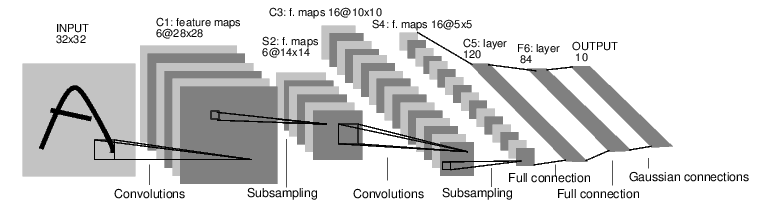

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5) # 1 channel, 6 output channels, 5*5 square conv kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        # affine operation y=Wx+b
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions expect batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
params = list(net.parameters())
print(len(params))
print(params[0].size())
print(params[2].size())

10
torch.Size([6, 1, 5, 5])
torch.Size([16, 6, 5, 5])


In [7]:
input = torch.randn(1,1,32,32)
out = net.forward(input)
print(out)

torch.Size([1, 16, 5, 5])
torch.Size([1, 400])
tensor([[-0.1659, -0.0287,  0.0102,  0.0995, -0.0792, -0.0725,  0.0410, -0.0346,
         -0.0032, -0.0506]], grad_fn=<AddmmBackward>)


In [9]:
net.zero_grad()
out.backward(torch.randn(1,10)) # just for example

In [14]:
net.conv1.parameters

<bound method Module.parameters of Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))>

`torch.nn` only supports mini-batches. The entire `torch.nn` package only supports inputs that are a mini-batch of samples, and not a single sample.

For example, `nn.Conv2d` will take in a 4D Tensor of `nSamples x nChannels x Height x Width.`

If you have a single sample, just use `input.unsqueeze(0)` to add a fake batch dimension.

### Loss function

In [15]:
output = net(input)
target = torch.randn(10) # a dummy target for example
target = target.view(1, -1) # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.9537, grad_fn=<MseLossBackward>)


In [18]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

### Backprop

In [19]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0008, -0.0028,  0.0091, -0.0041, -0.0062, -0.0030])


### Update weights
#### `weight = weight - learing_rate * gradient`

In [21]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(learning_rate * f.grad.data)

#### Optimizer 

In [22]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in training loop
optimizer.zero_grad()
output = net(input)
loss = criterion(output,target)
optimizer.step() # Does the update